# Building a Voice-Powered RAG Agent with NVIDIA Nemotron Models

This notebook walks you through building an end-to-end AI agent that combines voice input, multimodal retrieval, safety guardrails, and long-context reasoning using NVIDIA's Nemotron model family.

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                        VOICE-POWERED RAG AGENT                              │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│   ┌─────────┐    ┌─────────┐    ┌─────────┐    ┌─────────┐    ┌─────────┐   │
│   │  Voice  │───>│   ASR   │───>│   RAG   │───>│   LLM   │───>│ Safety  │   │
│   │  Input  │    │ (NeMo)  │    │ Embed+  │    │ Reason  │    │  Guard  │   │
│   └─────────┘    └─────────┘    │ Rerank  │    └─────────┘    └─────────┘   │
│                                 └─────────┘                         │       │
│                                      │                              │       │
│                                      v                              v       │
│                                 ┌─────────┐                   ┌─────────┐   │
│                                 │  FAISS  │                   │  Safe   │   │
│                                 │  Index  │                   │ Response│   │
│                                 └─────────┘                   └─────────┘   │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

## Models Used

| Component | Model | Deployment |
|-----------|-------|------------|
| Speech-to-Text | `nemotron-speech-streaming-en-0.6b` | Self-hosted (NeMo) |
| Embeddings | `llama-nemotron-embed-vl-1b-v2` | Self-hosted (Transformers) |
| Reranking | `llama-nemotron-rerank-vl-1b-v2` | Self-hosted (Transformers) |
| Vision-Language | `nemotron-nano-12b-v2-vl` | NVIDIA API |
| Reasoning | `nemotron-3-nano-30b-a3b` | NVIDIA API |
| Safety | `Llama-3.1-Nemotron-Safety-Guard-8B-v3` | Self-hosted (Transformers) |

## Prerequisites

- NVIDIA GPU with 24GB+ VRAM (for self-hosted models)
- NVIDIA API key (for cloud-hosted reasoning models)
- Python 3.10+

---

## Step 1: Environment Setup

Before we begin, we need to install the required dependencies and configure API access.

**What gets installed:**
- **LangChain/LangGraph**: Agent orchestration framework
- **Transformers + PyTorch**: For running local embedding, reranking, and safety models
- **FAISS**: Vector similarity search
- **NeMo Toolkit**: NVIDIA's ASR framework

In [1]:
import os
import getpass

# Set up NVIDIA API key for cloud-hosted models
if not os.environ.get("NVIDIA_API_KEY"):
    os.environ["NVIDIA_API_KEY"] = getpass.getpass("Enter your NVIDIA API Key: ")

NVIDIA_API_KEY = os.environ["NVIDIA_API_KEY"]

print("✅ Environment configured successfully!")


✅ Environment configured successfully!


In [2]:
# Verify GPU availability
import torch

if torch.cuda.is_available():
    print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ No GPU detected. Self-hosted models will run slowly on CPU.")

✅ GPU available: NVIDIA RTX 6000 Ada Generation
   Memory: 47.6 GB


---

## Step 2: Ground the Agent with Multimodal RAG

Retrieval-Augmented Generation (RAG) grounds our agent in real data, preventing hallucinations by providing factual context for every response.

```
┌─────────────────────────────────────────────────────────────────┐
│                    MULTIMODAL RAG PIPELINE                      │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│   INDEXING (Offline)                                            │
│   ┌──────────┐    ┌──────────┐    ┌──────────┐                  │
│   │  Text    │───>│  Embed   │───>│  FAISS   │                  │
│   │  Docs    │    │  Model   │    │  Index   │                  │
│   └──────────┘    └──────────┘    └──────────┘                  │
│   ┌──────────┐         │                                        │
│   │  Images  │─────────┘                                        │
│   └──────────┘                                                  │
│                                                                 │
│   RETRIEVAL (Online)                                            │
│   ┌──────────┐    ┌──────────┐    ┌──────────┐    ┌──────────┐  │
│   │  Query   │───>│  Embed   │───>│  Search  │───>│  Rerank  │  │
│   │          │    │  Query   │    │  Top-K   │    │  Top-N   │  │
│   └──────────┘    └──────────┘    └──────────┘    └──────────┘  │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

### 2.1 Load the Embedding Model

The `llama-nemotron-embed-vl-1b-v2` model creates semantic vector representations of both text and images. This allows us to:

- **Text-only embedding**: Standard document search
- **Image-only embedding**: Search over screenshots, diagrams, slides
- **Image+Text pairs**: Maximum retrieval accuracy for rich documents

The model uses different context lengths for each mode to optimize quality.

In [3]:
import torch
from transformers import AutoModel
from typing import List, Optional
from PIL import Image
from huggingface_hub import login
import os
import getpass

# Authenticate with HuggingFace for private/gated models
if not os.environ.get("HF_TOKEN"):
    os.environ["HF_TOKEN"] = getpass.getpass("Enter your HuggingFace Token: ")

login(token=os.environ["HF_TOKEN"])
print("✅ Logged into HuggingFace!")

class NemotronVLEmbeddings:
    """Custom multimodal embedding model using llama-nemotron-embed-vl-1b-v2."""
    
    def __init__(self, model_name: str = "nvidia/llama-nemotron-embed-vl-1b-v2"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        print(f"Loading embedding model: {model_name}...")
        self.model = AutoModel.from_pretrained(
            model_name,
            torch_dtype=torch.bfloat16,
            trust_remote_code=True,
            device_map="auto",
            attn_implementation="eager",  # Use standard attention (Flash Attention not required)
        ).eval()
        
        # Force eager attention on nested language model (fix for Flash Attention not installed)
        if hasattr(self.model, 'language_model') and hasattr(self.model.language_model, 'config'):
            self.model.language_model.config._attn_implementation = "eager"
        
        # Configure processor for different modalities
        self.model.processor.p_max_length = 8192  # Text-only default
        self.model.processor.max_input_tiles = 6
        self.model.processor.use_thumbnail = True
        print("✅ Embedding model loaded!")
    
    def embed_query(self, text: str) -> List[float]:
        """Embed a text query."""
        with torch.inference_mode():
            embeddings = self.model.encode_queries([text])
            return embeddings[0].cpu().float().numpy().tolist()
    
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Embed text documents."""
        with torch.inference_mode():
            embeddings = self.model.encode_documents(texts=texts)
            return embeddings.cpu().float().numpy().tolist()
    
    def embed_images(self, images: List[Image.Image]) -> List[List[float]]:
        """Embed document images."""
        self.model.processor.p_max_length = 2048  # Image mode
        with torch.inference_mode():
            embeddings = self.model.encode_documents(images=images)
        self.model.processor.p_max_length = 8192  # Reset
        return embeddings.cpu().float().numpy().tolist()
    
    def embed_image_text_pairs(self, images: List[Image.Image], texts: List[str]) -> List[List[float]]:
        """Embed image + text pairs for maximum retrieval accuracy."""
        self.model.processor.p_max_length = 10240  # Image+text mode
        with torch.inference_mode():
            embeddings = self.model.encode_documents(images=images, texts=texts)
        self.model.processor.p_max_length = 8192  # Reset
        return embeddings.cpu().float().numpy().tolist()

# Initialize the embedding model
embeddings_model = NemotronVLEmbeddings()

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


✅ Logged into HuggingFace!
Loading embedding model: nvidia/llama-nemotron-embed-vl-1b-v2...


config.json:   0%|          | 0.00/5.93k [00:00<?, ?B/s]

configuration_llama_nemotron_vl.py:   0%|          | 0.00/4.84k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/llama-nemotron-embed-vl-1b-v2:
- configuration_llama_nemotron_vl.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_llama_nemotron_vl.py:   0%|          | 0.00/22.0k [00:00<?, ?B/s]

processing_llama_nemotron_vl.py:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/llama-nemotron-embed-vl-1b-v2:
- processing_llama_nemotron_vl.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/nvidia/llama-nemotron-embed-vl-1b-v2:
- modeling_llama_nemotron_vl.py
- processing_llama_nemotron_vl.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/56.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

✅ Embedding model loaded!


### 2.2 Load the Reranking Model

Initial retrieval casts a wide net using fast vector similarity. The reranker then performs **deeper query-document interaction** to surface the most relevant results.

**Why rerank?** Embedding-based retrieval is fast but approximate. The reranker reads each candidate document alongside the query, enabling cross-attention between them. This improves accuracy by ~6-7% on benchmarks.

The `llama-nemotron-rerank-vl-1b-v2` model handles both text and image documents, using the same multimodal architecture as the embedding model.

In [4]:
from transformers import AutoModelForSequenceClassification, AutoProcessor

class NemotronVLReranker:
    """Multimodal reranker using llama-nemotron-rerank-vl-1b-v2."""
    
    def __init__(self, model_name: str = "nvidia/llama-nemotron-rerank-vl-1b-v2"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        print(f"Loading reranking model: {model_name}...")
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            torch_dtype=torch.bfloat16,
            trust_remote_code=True,
            device_map="auto",
            attn_implementation="eager",  # Use standard attention (Flash Attention not required)
        ).eval()
        
        # Force eager attention on nested language model (fix for Flash Attention not installed)
        # For SequenceClassification models, the path is model.model.language_model
        if hasattr(self.model, 'model') and hasattr(self.model.model, 'language_model'):
            self.model.model.language_model.config._attn_implementation = "eager"
        
        self.processor = AutoProcessor.from_pretrained(
            model_name,
            trust_remote_code=True,
            max_input_tiles=6,
            use_thumbnail=True,
            rerank_max_length=8192
        )
        print("✅ Reranking model loaded!")
    
    def rerank(
        self,
        query: str,
        documents: List[dict],  # [{"text": ..., "image": ...}]
        top_k: int = 5
    ) -> List[dict]:
        """Rerank documents by relevance to the query."""
        
        # Build examples for the reranker
        examples = []
        for doc in documents:
            example = {
                "question": query,
                "doc_text": doc.get("text", ""),
                "doc_image": doc.get("image", "")
            }
            examples.append(example)
        
        # Process and run inference
        batch_dict = self.processor.process_queries_documents_crossencoder(examples)
        batch_dict = {
            k: v.to(self.device) if isinstance(v, torch.Tensor) else v
            for k, v in batch_dict.items()
        }
        
        with torch.no_grad():
            outputs = self.model(**batch_dict, return_dict=True)
        
        # Get scores and sort
        logits = outputs.logits.squeeze(-1).cpu().numpy()
        scored_docs = [(doc, score) for doc, score in zip(documents, logits)]
        scored_docs.sort(key=lambda x: x[1], reverse=True)
        
        return [doc for doc, _ in scored_docs[:top_k]]

# Initialize the reranker
reranker = NemotronVLReranker()

Loading reranking model: nvidia/llama-nemotron-rerank-vl-1b-v2...


config.json:   0%|          | 0.00/6.08k [00:00<?, ?B/s]

configuration_llama_nemotron_vl.py:   0%|          | 0.00/5.69k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/llama-nemotron-rerank-vl-1b-v2:
- configuration_llama_nemotron_vl.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_llama_nemotron_vl.py:   0%|          | 0.00/22.1k [00:00<?, ?B/s]

processing_llama_nemotron_vl.py:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/llama-nemotron-rerank-vl-1b-v2:
- processing_llama_nemotron_vl.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/nvidia/llama-nemotron-rerank-vl-1b-v2:
- modeling_llama_nemotron_vl.py
- processing_llama_nemotron_vl.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

✅ Reranking model loaded!


### 2.3 Build a Sample Knowledge Base

Let's create a small knowledge base with both text and images to demonstrate multimodal retrieval. In production, you would index your actual documents, PDFs, and images here.

**Sample topics:**
- NVIDIA Isaac Lab (robotics)
- Autonomous vehicles (NVIDIA DRIVE)
- Nemotron 3 Nano architecture
- Genomics research (Evo-2)
- RAG fundamentals

In [5]:
import requests
from io import BytesIO
import numpy as np

# Sample documents (text + images)
sample_documents = [
    {
        "id": "doc_1",
        "text": "NVIDIA Isaac Lab is a unified framework for robot learning built on Isaac Sim. It provides modular components for locomotion, manipulation, and navigation tasks.",
        "image_url": "https://developer.download.nvidia.com/images/isaac/nvidia-isaac-lab-1920x1080.jpg",
        "has_image": True
    },
    {
        "id": "doc_2", 
        "text": "Autonomous vehicles use AI for perception, planning, and control. NVIDIA DRIVE provides the compute platform for Level 4 autonomous driving.",
        "image_url": "https://blogs.nvidia.com/wp-content/uploads/2018/01/automotive-key-visual-corp-blog-level4-av-og-1280x680-1.png",
        "has_image": True
    },
    {
        "id": "doc_3",
        "text": "Nemotron 3 Nano is a family of efficient language models with up to 1M token context. It uses a Mamba-Transformer hybrid architecture for computational efficiency.",
        "image_url": None,
        "has_image": False
    },
    {
        "id": "doc_4",
        "text": "NVIDIA Evo-2 is a biological foundation model for analyzing DNA, RNA, and protein sequences. It enables genomic research and drug discovery applications.",
        "image_url": "https://developer-blogs.nvidia.com/wp-content/uploads/2025/02/hc-press-evo2-nim-25-featured-b.jpg",
        "has_image": True
    },
    {
        "id": "doc_5",
        "text": "RAG (Retrieval Augmented Generation) improves LLM accuracy by grounding responses in retrieved documents. It reduces hallucinations and enables knowledge updates without retraining.",
        "image_url": None,
        "has_image": False
    }
]

# Load images
def load_image_from_url(url: str) -> Optional[Image.Image]:
    """Load an image from a URL."""
    if not url:
        return None
    try:
        response = requests.get(url, timeout=10)
        return Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Failed to load image: {e}")
        return None

# Load all document images
for doc in sample_documents:
    doc["image"] = load_image_from_url(doc.get("image_url"))

print(f"✅ Loaded {len(sample_documents)} documents")
print(f"   - With images: {sum(1 for d in sample_documents if d['image'] is not None)}")
print(f"   - Text only: {sum(1 for d in sample_documents if d['image'] is None)}")

✅ Loaded 5 documents
   - With images: 3
   - Text only: 2


In [7]:
# Create embeddings for all documents
print("Creating document embeddings...")

document_embeddings = []
for doc in sample_documents:
    if doc["image"] is not None:
        # Use image+text embedding for maximum accuracy
        emb = embeddings_model.embed_image_text_pairs([doc["image"]], [doc["text"]])[0]
    else:
        # Text-only embedding
        emb = embeddings_model.embed_documents([doc["text"]])[0]
    document_embeddings.append(emb)

document_embeddings = np.array(document_embeddings, dtype=np.float32)
print(f"✅ Created embeddings with shape: {document_embeddings.shape}")

Creating document embeddings...
✅ Created embeddings with shape: (5, 2048)


In [8]:
# Build FAISS index for fast similarity search
import faiss

# Normalize embeddings for cosine similarity
faiss.normalize_L2(document_embeddings)

# Create index
dimension = document_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner product = cosine similarity after normalization
index.add(document_embeddings)

print(f"✅ FAISS index created with {index.ntotal} vectors")

✅ FAISS index created with 5 vectors


In [9]:
def retrieve_and_rerank(query: str, top_k: int = 3) -> List[dict]:
    """Retrieve documents and rerank them for a given query."""
    
    # Step 1: Embed the query
    query_embedding = np.array([embeddings_model.embed_query(query)], dtype=np.float32)
    faiss.normalize_L2(query_embedding)
    
    # Step 2: Search the index (retrieve more than we need for reranking)
    k_retrieve = min(len(sample_documents), top_k * 2)
    scores, indices = index.search(query_embedding, k_retrieve)
    
    # Step 3: Get candidate documents
    candidates = [sample_documents[i] for i in indices[0]]
    
    # Step 4: Rerank candidates
    reranked = reranker.rerank(query, candidates, top_k=top_k)
    
    return reranked

# Test retrieval
test_query = "How is AI used in robotics?"
results = retrieve_and_rerank(test_query, top_k=2)

print(f"Query: {test_query}")
print(f"\nTop {len(results)} results:")
for i, doc in enumerate(results, 1):
    print(f"  {i}. {doc['text'][:100]}...")
    print(f"     Has image: {doc['image'] is not None}")


Query: How is AI used in robotics?

Top 2 results:
  1. NVIDIA Isaac Lab is a unified framework for robot learning built on Isaac Sim. It provides modular c...
     Has image: True
  2. Autonomous vehicles use AI for perception, planning, and control. NVIDIA DRIVE provides the compute ...
     Has image: True


---

## Step 3: Add Real-Time Speech with Nemotron Speech ASR

Now we add voice input capability. The `nemotron-speech-streaming-en-0.6b` model converts spoken audio to text with ultra-low latency.

```
┌─────────────────────────────────────────────────────────────┐
│                    ASR PIPELINE                             │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│   ┌──────────┐    ┌──────────┐    ┌──────────┐              │
│   │  Audio   │───>│  NeMo    │───>│  Text    │              │
│   │  Stream  │    │  ASR     │    │  Output  │              │
│   └──────────┘    └──────────┘    └──────────┘              │
│                        │                                    │
│                        v                                    │
│              ┌─────────────────┐                            │
│              │ + Punctuation   │                            │
│              │ + Capitalization│                            │
│              └─────────────────┘                            │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

**Key features:**
- Trained on 285k-hour Granary dataset
- 7.16% average WER on Open ASR Leaderboard
- Cache-aware streaming for real-time applications
- Built-in punctuation and capitalization
- Configurable latency: 80ms to 1.1s chunk sizes

In [33]:
import torch
import nemo.collections.asr as nemo_asr
from omegaconf import OmegaConf
from typing import List
import soundfile as sf
import numpy as np
import tempfile
import os

class NemotronASR:
    """Speech-to-text using Nemotron Speech Streaming model."""
    
    def __init__(self, model_name: str = "nvidia/nemotron-speech-streaming-en-0.6b"):
        print(f"Loading ASR model: {model_name}...")
        self.model = nemo_asr.models.ASRModel.from_pretrained(model_name=model_name)
        self.model.eval()
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        
        self._disable_cuda_graphs()
        print("✅ ASR model loaded!")
    
    def _disable_cuda_graphs(self):
        """Disable CUDA graphs in the decoding pipeline."""
        try:
            if hasattr(self.model, 'decoding') and hasattr(self.model.decoding, 'decoding'):
                decoder = self.model.decoding.decoding
                if hasattr(decoder, 'decoding_computer') and decoder.decoding_computer is not None:
                    decoder.decoding_computer.cuda_graphs_mode = None
                    print("  → Disabled CUDA graphs on decoding_computer")
                    return
        except Exception as e:
            print(f"  → Direct patch failed: {e}")
        
        try:
            if hasattr(self.model, 'cfg') and hasattr(self.model.cfg, 'decoding'):
                decoding_cfg = OmegaConf.to_container(self.model.cfg.decoding, resolve=True)
                decoding_cfg = OmegaConf.create(decoding_cfg)
                OmegaConf.set_struct(decoding_cfg, False)
                
                if 'greedy' in decoding_cfg and decoding_cfg.greedy is not None:
                    decoding_cfg.greedy.cuda_graphs_mode = None
                
                self.model.change_decoding_strategy(decoding_cfg)
                
                if hasattr(self.model.decoding, 'decoding'):
                    decoder = self.model.decoding.decoding
                    if hasattr(decoder, 'decoding_computer') and decoder.decoding_computer is not None:
                        decoder.decoding_computer.cuda_graphs_mode = None
                
                print("  → Rebuilt decoding strategy with CUDA graphs disabled")
        except Exception as e:
            print(f"  → Config rebuild failed: {e}")
    
    def _to_mono(self, audio_path: str) -> str:
        """Convert audio to mono if needed, return path to mono file."""
        audio, sr = sf.read(audio_path)
        
        # Already mono
        if len(audio.shape) == 1 or audio.shape[1] == 1:
            return audio_path
        
        # Convert to mono by averaging channels
        audio_mono = np.mean(audio, axis=1)
        
        # Write to temp file
        temp_file = tempfile.NamedTemporaryFile(suffix='.wav', delete=False)
        sf.write(temp_file.name, audio_mono, sr)
        return temp_file.name
    
    def transcribe(self, audio_path: str) -> str:
        """Transcribe an audio file to text."""
        mono_path = self._to_mono(audio_path)
        try:
            transcriptions = self.model.transcribe([mono_path])
            return transcriptions[0] if transcriptions else ""
        finally:
            # Clean up temp file if we created one
            if mono_path != audio_path:
                os.unlink(mono_path)
    
    def transcribe_batch(self, audio_paths: List[str]) -> List[str]:
        """Transcribe multiple audio files."""
        mono_paths = [self._to_mono(p) for p in audio_paths]
        try:
            return self.model.transcribe(mono_paths)
        finally:
            for mono_path, orig_path in zip(mono_paths, audio_paths):
                if mono_path != orig_path:
                    os.unlink(mono_path)

asr_model = NemotronASR()

Loading ASR model: nvidia/nemotron-speech-streaming-en-0.6b...
[NeMo I 2026-01-02 17:44:56 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2026-01-02 17:44:56 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    use_lhotse: true
    skip_missing_manifest_entries: true
    input_cfg: /lustre/fs12/portfolios/llmservice/projects/llmservice_nemo_speechlm/users/weiqingw/manifests/input_cfg/am-os_fl_ll_mc_mm_mo_no_su_yo_yt_gsc_en.yaml
    tarred_audio_filepaths: null
    manifest_filepath: null
    sample_rate: 16000
    shuffle: true
    num_workers: 2
    pin_memory: true
    max_duration: 40.0
    min_duration: 0.1
    text_field: answer
    batch_duration: null
    use_bucketing: true
    max_tps:
    - 10.92
    - 11.16
    - 10.68
    - 10.22
    - 9.98
    - 9.67
    - 9.5
    - 9.36
    - 9.04
    - 9.38
    - 8.81
    - 8.78
    - 8.24
    - 8.85
    - 9.25
    bucket_duration_bins:
    - - 5.76
      - 62
    - - 7.12
      - 77
    - - 8.32
      - 83
  

[NeMo I 2026-01-02 17:44:56 nemo_logging:393] PADDING: 0
[NeMo I 2026-01-02 17:44:58 nemo_logging:393] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.005, 'clamp': -1.0}
[NeMo I 2026-01-02 17:44:58 nemo_logging:393] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.005, 'clamp': -1.0}
[NeMo I 2026-01-02 17:44:58 nemo_logging:393] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.005, 'clamp': -1.0}
[NeMo I 2026-01-02 17:44:59 nemo_logging:393] Model EncDecRNNTBPEModel was successfully restored from /home/chris/.cache/huggingface/hub/models--nvidia--nemotron-speech-streaming-en-0.6b/snapshots/e730059607cecd9cccf501d8a39f5d22f0993db8/nemotron-speech-streaming-en-0.6b.nemo.
  → Disabled CUDA graphs on decoding_computer
✅ ASR model loaded!


In [34]:
# Download a sample audio file for testing
import urllib.request

sample_audio_path = "robotics.flac"

# Transcribe the sample
transcription = asr_model.transcribe(sample_audio_path)
print(f"\n📝 Transcription: {transcription}")


[NeMo W 2026-01-02 17:45:02 nemo_logging:405] The following configuration keys are ignored by Lhotse dataloader: use_start_end_token
[NeMo W 2026-01-02 17:45:02 nemo_logging:405] You are using a non-tarred dataset and requested tokenization during data sampling (pretokenize=True). This will cause the tokenization to happen in the main (GPU) process,possibly impacting the training speed if your tokenizer is very large.If the impact is noticable, set pretokenize=False in dataloader config.(note: that will disable token-per-second filtering and 2D bucketing features)
Transcribing: 1it [00:00, 21.26it/s]


📝 Transcription: Hypothesis(score=-465.7001953125, y_sequence=tensor([112, 127,  41, 685, 342, 291,  32, 120, 143, 160, 358, 963,  54, 589,
        977]), text='Could you please tell me about robotics?', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngram_lm_state=None, tokens=None, last_token=None, token_duration=None, last_frame=None)


---

## Step 4: Enforce Safety with Nemotron Content Safety and PII Detection

Production agents need guardrails. The `Llama-3.1-Nemotron-Safety-Guard-8B-v3` model checks both user inputs and agent outputs for safety violations.

```
┌─────────────────────────────────────────────────────────────┐
│                    SAFETY PIPELINE                          │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│   ┌──────────┐         ┌──────────────────┐                 │
│   │  User    │────────>│                  │                 │
│   │  Query   │         │   Safety Guard   │──> Safe/Unsafe  │
│   └──────────┘         │                  │                 │
│                        │  23 Categories:  │                 │
│   ┌──────────┐         │  - Violence      │                 │
│   │  Agent   │────────>│  - PII/Privacy   │                 │
│   │ Response │         │  - Harassment    │                 │
│   └──────────┘         │  - Fraud         │                 │
│                        │  - Malware       │                 │
│                        │  - etc.          │                 │
│                        └──────────────────┘                 │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

**Key features:**
- Multilingual support (20+ languages)
- PII detection (emails, SSNs, phone numbers)
- Cultural context awareness
- 23 safety categories
- Works with noisy ASR output

In [35]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from jinja2 import Template
import json

class NemotronSafetyGuard:
    """Content safety and PII detection using Llama-3.1-Nemotron-Safety-Guard-8B-v3."""
    
    SAFETY_TEMPLATE = Template("""Task: Check if there is unsafe content in the user or agent messages in the below conversation in accordance with our safety policy with the below categories. Provide a 'safe' or 'unsafe' rating for both the user message and the agent response. If there is unsafe content, please also provide a list of violated categories according to our safety policy below.

<BEGIN UNSAFE CONTENT CATEGORIES>
S1: Violence. 
S2: Sexual. 
S3: Criminal Planning/Confessions. 
S4: Guns and Illegal Weapons. 
S5: Controlled/Regulated Substances. 
S6: Suicide and Self Harm. 
S7: Sexual (minor). 
S8: Hate/Identity Hate. 
S9: PII/Privacy. 
S10: Harassment. 
S11: Threat. 
S12: Profanity. 
S13: Needs Caution. 
S14: Other. 
S15: Manipulation. 
S16: Fraud/Deception. 
S17: Malware. 
S18: High Risk Gov Decision Making. 
S19: Political/Misinformation/Conspiracy. 
S20: Copyright/Trademark/Plagiarism. 
S21: Unauthorized Advice. 
S22: Illegal Activity. 
S23: Immoral/Unethical. 
<END UNSAFE CONTENT CATEGORIES>

<BEGIN CONVERSATION>

user: {{ query }}
{% if response %}
response: agent: {{ response }}
{% endif %}
<END CONVERSATION>

Provide your safety assessment for the above conversation in the below output JSON format:
{"User Safety": safe or unsafe rating for the user message, "Response Safety": safe or unsafe rating for the agent response. Omit if no agent response present. "Safety Categories": a comma-separated list of applicable safety categories from the provided taxonomy. Omit if all safe.}

Do not include anything other than the output JSON in your response.
Output JSON: """)
    
    def __init__(self, model_name: str = "nvidia/Llama-3.1-Nemotron-Safety-Guard-8B-v3"):
        print(f"Loading safety model: {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.bfloat16,
            device_map="auto"
        ).eval()
        print("✅ Safety model loaded!")
    
    def check_safety(self, query: str, response: Optional[str] = None) -> dict:
        """Check content safety for a query and optional response."""
        
        # Construct the prompt
        constructed_prompt = self.SAFETY_TEMPLATE.render(query=query, response=response)
        
        # Apply chat template
        prompt = self.tokenizer.apply_chat_template(
            [{"role": "user", "content": constructed_prompt}],
            add_generation_prompt=True,
            tokenize=False
        )
        
        # Generate response
        inputs = self.tokenizer([prompt], return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(**inputs, max_new_tokens=100, do_sample=False)
        prompt_len = inputs["input_ids"].shape[-1]
        result = self.tokenizer.decode(outputs[0][prompt_len:], skip_special_tokens=True)
        
        # Parse JSON response
        try:
            return json.loads(result)
        except json.JSONDecodeError:
            return {"User Safety": "unknown", "raw_response": result}
    
    def is_safe(self, query: str, response: Optional[str] = None) -> bool:
        """Quick check if content is safe."""
        result = self.check_safety(query, response)
        user_safe = result.get("User Safety", "unsafe").lower() == "safe"
        response_safe = result.get("Response Safety", "safe").lower() == "safe"
        return user_safe and response_safe

# Initialize safety guard
safety_guard = NemotronSafetyGuard()

Loading safety model: nvidia/Llama-3.1-Nemotron-Safety-Guard-8B-v3...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/941 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

✅ Safety model loaded!


In [36]:
# Test safety checking
test_cases = [
    {"query": "How does AI improve robotics?", "response": "AI enables robots to perceive and act autonomously."},
    {"query": "My email is john@example.com and my SSN is 123-45-6789", "response": None},
]

print("🛡️ Safety Check Results:")
for i, test in enumerate(test_cases, 1):
    result = safety_guard.check_safety(test["query"], test.get("response"))
    print(f"\n{i}. Query: {test['query'][:50]}...")
    print(f"   Result: {result}")


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🛡️ Safety Check Results:


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



1. Query: How does AI improve robotics?...
   Result: {'User Safety': 'safe', 'Response Safety': 'safe'}

2. Query: My email is john@example.com and my SSN is 123-45-...
   Result: {'User Safety': 'unsafe', 'Safety Categories': 'PII/Privacy'}


---

## Step 5: Add Long-Context Reasoning with Nemotron 3 Nano

With retrieval, speech, and safety in place, we add the reasoning engine. **Nemotron 3 Nano** processes the retrieved context and generates intelligent responses.

```
┌─────────────────────────────────────────────────────────────┐
│                 REASONING PIPELINE                          │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│   ┌──────────┐                                              │
│   │ Retrieved│─────┐                                        │
│   │   Docs   │     │                                        │
│   └──────────┘     │    ┌────────────────┐                  │
│                    ├───>│                │                  │
│   ┌──────────┐     │    │  Nemotron 3    │    ┌──────────┐  │
│   │  Image   │─────┤    │     Nano       │───>│ Response │  │
│   │  Descs   │     │    │                │    └──────────┘  │
│   └──────────┘     │    │  1M tokens     │                  │
│                    │    │  Mamba+Trans   │                  │
│   ┌──────────┐     │    └────────────────┘                  │
│   │   User   │─────┘           │                            │
│   │  Query   │          ┌──────┴──────┐                     │
│   └──────────┘          │  Optional   │                     │
│                         │  Thinking   │                     │
│                         │    Mode     │                     │
│                         └─────────────┘                     │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

**Architecture highlights:**
- **1M token context**: Fit entire document collections in a single request
- **Mamba-Transformer hybrid**: Efficient inference on long sequences
- **Thinking mode**: Optional step-by-step reasoning for complex queries

For images in retrieved documents, we first use **Nemotron Nano VL** to describe them, then include those descriptions in the context for Nemotron 3 Nano.

In [37]:
from openai import OpenAI
import base64

class NemotronLLM:
    """Wrapper for Nemotron models via NVIDIA API."""
    
    def __init__(self, api_key: str):
        self.client = OpenAI(
            base_url="https://integrate.api.nvidia.com/v1",
            api_key=api_key
        )
    
    def generate(
        self,
        prompt: str,
        model: str = "nvidia/nemotron-3-nano-30b-a3b",
        enable_thinking: bool = True,
        max_tokens: int = 4096
    ) -> str:
        """Generate a response using Nemotron 3 Nano."""
        
        extra_body = {}
        if enable_thinking:
            extra_body = {
                "reasoning_budget": 4096,
                "chat_template_kwargs": {"enable_thinking": True}
            }
        
        completion = self.client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            top_p=0.95,
            max_tokens=max_tokens,
            extra_body=extra_body if extra_body else None,
            stream=False
        )
        
        return completion.choices[0].message.content
    
    def describe_image(
        self,
        image: Image.Image,
        query: str = "Describe this image in detail."
    ) -> str:
        """Describe an image using Nemotron Nano VL."""
        
        # Convert image to base64
        from io import BytesIO
        buffer = BytesIO()
        image.save(buffer, format="PNG")
        base64_image = base64.b64encode(buffer.getvalue()).decode("utf-8")
        
        completion = self.client.chat.completions.create(
            model="nvidia/nemotron-nano-12b-v2-vl",
            messages=[
                {
                    "role": "system",
                    "content": "/no_think"  # Fast mode without extended reasoning
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": query},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            max_tokens=1024,
            temperature=0.7
        )
        
        return completion.choices[0].message.content

# Initialize LLM
llm = NemotronLLM(NVIDIA_API_KEY)
print("✅ Nemotron LLM initialized!")


✅ Nemotron LLM initialized!


In [38]:
# Test the LLM
test_prompt = """Based on the following context, answer the question.

Context:
NVIDIA Isaac Lab is a unified framework for robot learning built on Isaac Sim. 
It provides modular components for locomotion, manipulation, and navigation tasks.

Question: What is Isaac Lab used for?

Answer:"""

response = llm.generate(test_prompt, enable_thinking=False)
print(f"🤖 Response: {response}")

🤖 Response: 
Isaac Lab is a unified framework for robot learning that lets you build, train, and test AI‑driven robotic behaviors.  It provides modular components for tasks such as **locomotion, manipulation, and navigation**, enabling developers to create and experiment with intelligent robot control pipelines in the Isaac Sim environment.


---

## Step 6: Build the Complete Agent with LangGraph

Now we wire everything together using **LangGraph**, which orchestrates the agent as a directed graph of processing nodes.

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                         LANGGRAPH WORKFLOW                                  │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│   START                                                                     │
│     │                                                                       │
│     v                                                                       │
│   ┌─────────────┐    ┌─────────────┐    ┌─────────────┐                     │
│   │ transcribe  │───>│  retrieve   │───>│  describe   │                     │
│   │             │    │             │    │   images    │                     │
│   │ Audio->Text │    │ Query->Docs │    │ Image->Text │                     │
│   └─────────────┘    └─────────────┘    └─────────────┘                     │
│                                               │                             │
│                                               v                             │
│                      ┌─────────────┐    ┌─────────────┐                     │
│                      │   safety    │<───│  generate   │                     │
│                      │   check     │    │             │                     │
│                      │             │    │ Context->   │                     │
│                      │ Safe/Unsafe │    │  Response   │                     │
│                      └─────────────┘    └─────────────┘                     │
│                            │                                                │
│                            v                                                │
│                          END                                                │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

**Agent state** flows through each node, accumulating:
- `transcription`: Text from voice input
- `retrieved_docs`: Relevant documents from RAG
- `image_descriptions`: Text descriptions of any images
- `response`: Final generated answer
- `is_safe`: Safety check result

First, let's define the state schema:

In [39]:
from typing import TypedDict
from langgraph.graph import StateGraph, END

# Define the agent state
class AgentState(TypedDict):
    # Input
    audio_path: Optional[str]
    text_query: Optional[str]
    
    # Processing
    transcription: str
    retrieved_docs: List[dict]
    image_descriptions: List[str]
    
    # Output
    response: str
    safety_result: dict
    is_safe: bool

In [40]:
# Define workflow nodes

def transcribe_audio(state: AgentState) -> AgentState:
    """Transcribe audio input to text."""
    if state.get("audio_path"):
        transcription = asr_model.transcribe(state["audio_path"])
    else:
        transcription = state.get("text_query", "")
    
    return {"transcription": transcription}


def retrieve_documents(state: AgentState) -> AgentState:
    """Retrieve and rerank relevant documents."""
    query = state["transcription"]
    docs = retrieve_and_rerank(query, top_k=3)
    return {"retrieved_docs": docs}


def describe_images(state: AgentState) -> AgentState:
    """Describe any images in retrieved documents."""
    descriptions = []
    query = state["transcription"]
    
    for doc in state["retrieved_docs"]:
        if doc.get("image") is not None:
            desc = llm.describe_image(
                doc["image"],
                f"Describe this image in the context of: {query}"
            )
            descriptions.append(f"[Image Description]: {desc}")
    
    return {"image_descriptions": descriptions}


def generate_response(state: AgentState) -> AgentState:
    """Generate the final response using Nemotron 3 Nano."""
    
    # Build context from retrieved docs
    context_parts = []
    for doc in state["retrieved_docs"]:
        context_parts.append(f"- {doc['text']}")
    
    # Add image descriptions
    for desc in state.get("image_descriptions", []):
        context_parts.append(desc)
    
    context = "\n".join(context_parts)
    
    prompt = f"""You are a helpful AI assistant. Answer the user's question based on the provided context.

Context:
{context}

User Question: {state["transcription"]}

Provide a clear, accurate, and helpful response based on the context above.

Response:"""
    
    response = llm.generate(prompt, enable_thinking=True)
    return {"response": response}


def check_safety(state: AgentState) -> AgentState:
    """Check the safety of the response."""
    result = safety_guard.check_safety(
        state["transcription"],
        state["response"]
    )
    
    is_safe = (
        result.get("User Safety", "unsafe").lower() == "safe" and
        result.get("Response Safety", "safe").lower() == "safe"
    )
    
    return {"safety_result": result, "is_safe": is_safe}


In [41]:
# Build the workflow graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("transcribe", transcribe_audio)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("describe_images", describe_images)
workflow.add_node("generate", generate_response)
workflow.add_node("safety_check", check_safety)

# Define edges
workflow.set_entry_point("transcribe")
workflow.add_edge("transcribe", "retrieve")
workflow.add_edge("retrieve", "describe_images")
workflow.add_edge("describe_images", "generate")
workflow.add_edge("generate", "safety_check")
workflow.add_edge("safety_check", END)

# Compile the graph
agent = workflow.compile()

print("✅ Agent workflow compiled!")


✅ Agent workflow compiled!


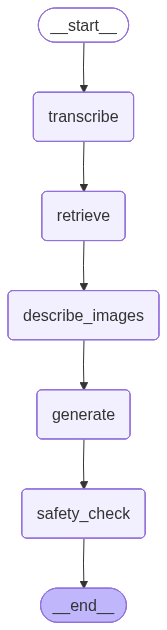

In [42]:
# Visualize the workflow (optional)
try:
    from IPython.display import Image as IPImage, display
    display(IPImage(agent.get_graph().draw_mermaid_png()))
except Exception:
    print("Workflow: transcribe → retrieve → describe_images → generate → safety_check → END")


In [ ]:
def run_agent(query: str = None, audio_path: str = None) -> dict:
    """Run the voice RAG agent with either text or audio input."""
    
    initial_state = {
        "audio_path": audio_path,
        "text_query": query,
        "transcription": "",
        "retrieved_docs": [],
        "image_descriptions": [],
        "response": "",
        "safety_result": {},
        "is_safe": True
    }
    
    result = agent.invoke(initial_state)
    
    return {
        "query": result["transcription"],
        "response": result["response"],
        "is_safe": result["is_safe"],
        "safety_details": result["safety_result"],
        "sources": [doc["id"] for doc in result["retrieved_docs"]]
    }

---

## Run the Complete Agent

The agent is ready. Let's test it with both text queries and audio input.

**Test flow:**
1. Query enters the agent (text or audio)
2. ASR transcribes audio to text (if needed)
3. RAG retrieves and reranks relevant documents
4. VL model describes any images in the results
5. Reasoning model generates a response
6. Safety guard validates the output
7. Safe response is returned

In [44]:
# Test with text input
print("🤖 Testing Voice RAG Agent")
print("=" * 50)

test_queries = [
    "How is AI used to improve robotics?",
    "What is Nemotron 3 Nano and what makes it efficient?",
    "Tell me about autonomous vehicles and NVIDIA DRIVE."
]

for query in test_queries:
    print(f"\n📝 Query: {query}")
    print("-" * 50)
    
    result = run_agent(query=query)
    
    print(f"🤖 Response: {result['response'][:500]}...")
    print(f"\n🛡️ Safety: {'✅ Safe' if result['is_safe'] else '⚠️ Unsafe'}")
    print(f"📚 Sources: {result['sources']}")
    print("=" * 50)

🤖 Testing Voice RAG Agent

📝 Query: How is AI used to improve robotics?
--------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🤖 Response: 
**AI enhances robotics in many inter‑related ways. Below are the main areas where AI adds capability, efficiency, and safety to robotic systems:**

| AI Function | How It Improves Robotics | Typical Techniques / Examples |
|-------------|--------------------------|------------------------------|
| **Perception & Sensing** | Interprets raw sensor data (camera, lidar, depth, force) to understand the surrounding world. | Machine‑learning vision models, sensor fusion, object detection, gesture/face...

🛡️ Safety: ✅ Safe
📚 Sources: ['doc_4', 'doc_1', 'doc_2']

📝 Query: What is Nemotron 3 Nano and what makes it efficient?
--------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🤖 Response: 
**Nemotron 3 Nano** is a compact, NVIDIA‑developed AI model that is designed to run efficiently on devices with limited compute resources—such as consumer‑grade laptops or edge hardware (e.g., NVIDIA Jetson modules). Its primary goal is to bring advanced AI capabilities (like real‑time inference on sensor streams) to everyday hardware without needing cloud services.

### What makes Nemotron 3 Nano efficient?

| Efficiency factor | How it works |
|-------------------|--------------|
| **Architec...

🛡️ Safety: ✅ Safe
📚 Sources: ['doc_4', 'doc_1', 'doc_2']

📝 Query: Tell me about autonomous vehicles and NVIDIA DRIVE.
--------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🤖 Response: 
**Autonomous Vehicles**

- **What they are:** Self‑driving cars (also called robotic or autonomous vehicles) can sense their environment and navigate without a human driver.  
- **How they work:**  
  - **Sensors** – cameras, radar, lidar, and other perception devices continuously collect data about the surroundings.  
  - **AI‑driven perception & decision‑making** – deep‑learning models process this data to detect objects, understand traffic rules, plan a safe path, and execute maneuvers such ...

🛡️ Safety: ✅ Safe
📚 Sources: ['doc_4', 'doc_1', 'doc_2']


In [45]:
# Test with audio input (using the sample audio)
print("\n🎤 Testing with Audio Input")
print("=" * 50)

result = run_agent(audio_path=sample_audio_path)

print(f"📝 Transcription: {result['query']}")
print(f"\n🤖 Response: {result['response'][:500]}...")
print(f"\n🛡️ Safety: {'✅ Safe' if result['is_safe'] else '⚠️ Unsafe'}")

[NeMo W 2026-01-02 17:47:49 nemo_logging:405] The following configuration keys are ignored by Lhotse dataloader: use_start_end_token
[NeMo W 2026-01-02 17:47:49 nemo_logging:405] You are using a non-tarred dataset and requested tokenization during data sampling (pretokenize=True). This will cause the tokenization to happen in the main (GPU) process,possibly impacting the training speed if your tokenizer is very large.If the impact is noticable, set pretokenize=False in dataloader config.(note: that will disable token-per-second filtering and 2D bucketing features)



🎤 Testing with Audio Input


Transcribing: 1it [00:00, 18.04it/s]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


📝 Transcription: Hypothesis(score=-465.7001953125, y_sequence=tensor([112, 127,  41, 685, 342, 291,  32, 120, 143, 160, 358, 963,  54, 589,
        977]), text='Could you please tell me about robotics?', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngram_lm_state=None, tokens=None, last_token=None, token_duration=None, last_frame=None)

🤖 Response: 
**Robotics** is a multidisciplinary field that brings together engineering, computer science, mathematics, and biology to design, build, and operate machines (robots) that can sense their environment, reason about it, and act upon it to achieve a goal. Below is a concise overview that ties together the key ideas highlighted in the context you provided.

---

## 1. What Is a Robot?

- **Definition**: A robot is a programmable machine that can automatically perform tasks—often repetitive or hazar...

🛡️ Safety: 

---

## Summary

You've built a complete voice-powered RAG agent using NVIDIA Nemotron models:

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                        WHAT YOU BUILT                                       │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│   Component          Model                           Purpose                │
│   ─────────          ─────                           ───────                │
│   ASR                nemotron-speech-streaming       Voice → Text           │
│   Embeddings         llama-nemotron-embed-vl         Semantic search        │
│   Reranking          llama-nemotron-rerank-vl        Sharpen accuracy       │
│   Vision-Language    nemotron-nano-12b-vl            Describe images        │
│   Reasoning          nemotron-3-nano-30b             Generate responses     │
│   Safety             Llama-3.1-Nemotron-Safety       Content moderation     │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

## Next Steps

- **Scale up**: Add more documents to your knowledge base
- **Deploy**: Use NVIDIA NIM for production-ready inference
- **Customize**: Fine-tune models on your domain-specific data
- **Stream**: Enable real-time streaming responses

## Resources

- [Nemotron Models on Hugging Face](https://huggingface.co/nvidia)
- [NVIDIA NIM](https://developer.nvidia.com/nim)
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [NVIDIA NeMo Framework](https://github.com/NVIDIA/NeMo)